# The Hunt for Continuous Waves
## Originally developed by Michael Lam, subverted by Jeff Hazboun

In [28]:
# Useful imports
#needed on home laptop:
from __future__ import division, print_function
%matplotlib inline 
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import libstempo as T
import libstempo.toasim as LT
import libstempo.plot as LP


In [29]:
#The following function is used to make fake pulsars. It needs the astropy SkyCoord module. 
from astropy.coordinates import SkyCoord

def make_fake_pulsar(DIR=""):
    '''
    Makes a fake pulsar par file
    '''
    output = "MODE 1\n"
    
    # Sphere Point Picking
    u = np.random.uniform()
    v = np.random.uniform()
    phi = 2*np.pi*u #using standard physics notation
    theta = np.arccos(2*v-1) - np.pi/2

    c = SkyCoord(phi,theta,frame='icrs',unit='rad')
    cstr = c.to_string('hmsdms')
    #print cstr
    RAJ = cstr.split(" ")[0].replace("h",":").replace("m",":")[:-1]
    DECJ = cstr.split(" ")[1].replace("d",":").replace("m",":")[:-1]
    cstr = cstr.replace(" ","")
    name = "J"+RAJ[0:2]+RAJ[3:5]+DECJ[0]+DECJ[1:3]+DECJ[4:6]

    output += "PSR      %s\n"%name

    
    output += "PEPOCH   50000.0\n"    
    output += "POSEPOCH   50000.0\n"

    period = 0.001*np.random.uniform(1,10) #seconds
    output += "F0       %0.10f 1\n"%(1.0/period)

    output += "RAJ      %s 1\n"%RAJ
    output += "DECJ     %s 1\n"%DECJ

    dist = np.random.uniform(0.1,5) #kpc
    output += "PX       %0.5f 1\n"%(1.0/dist)

    filename = "%s%s.par"%(DIR,name)
    with open(filename,'w') as FILE:
        FILE.write(output)

    return filename.encode('ascii','ignore')

## Introduction

Gravitational wave (GW) signals come in many different forms. In this exercise, we will focus on the "simplest" type: continuous gravitational waves from two inspiralling supermassive black holes. You will "observe" an array of pulsars and then run gravitational wave detection codes in order to infer properties about the system. This exercise is intended for more advanced students interested in learning both libstempo and PAL2.

## Observing Your Pulsar Timing Array

We have written a function for you to make a fake pulsar uniformly distributed across the sky. It takes a directory location (so you have your own workspace) and returns the location of the par file, which will be needed later. You can make as many as you'd like but we suggest making at least three, as below. Feel free to add more as you like, and you can certainly use loops if copying the code becomes to unwieldy!

In [30]:
par1 = make_fake_pulsar()
par2 = make_fake_pulsar()
par3 = make_fake_pulsar()
print(par1, par2, par3)

J2304+3108.par J0045-0455.par J2132+3150.par


In [ ]:
psr1 = LT.fakepulsar(par1,obstimes=t,toaerr=3,iters=7)

We provide a function below that takes the location of a pulsar parameter file and then pretends to observe the pulsar, also adding in a continuous wave coming from the Virgo Cluster. It returns a libstempo tempopulsar object and you can plot the residuals using `LP.plotres()`. By default, the gravitational wave strain is very large, just so you have some practice finding a strong signal.

In [31]:
def observe(par, noise=0.5, mass=5e9, fgw=1e-8):
    ''' Noise in microseconds, mass in solar masses'''
    t = np.arange(53000,56650,30.0) #observing dates for 10 years
    t += np.random.randn(len(t)) #observe every 30+/-1 days
    psr = LT.fakepulsar(parfile=par,
                        obstimes=t,
                        toaerr=noise)
    LT.add_equad(psr,equad=noise*1e-6,seed=42)
    # Virgo cluster: 12h27m +12d43'
    LT.add_cgw(psr, gwtheta=(12+43.0/60)*np.pi/180, gwphi=(12*15+27.0/60)*np.pi/180, mc=mass, dist=15, fgw=fgw, phase0=0, psi=0, inc=0, pdist=1.0,
               pphase=None, psrTerm=True, evolve=True,
               phase_approx=False, tref=0)
    psr.savetim('%s.tim'%par.split('.')[0])
    return psr
#print (12+43.0/60)*np.pi/180,(12*15+27.0/60)*np.pi/180 #perhaps useful for reading enterprise output

Use the function above and libstempo (read the docs!) to observe your pulsars and plot the residuals to see what they look like. Add more cells as necessary.

'\nfig1 = plt.figure(2, figsize=(10,10))\nax1, ax2, ax3 = fig1.add_subplot(311), fig1.add_subplot(312), fig1.add_subplot(313)\nax1.plot()\n'

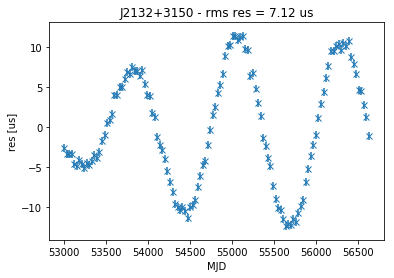

In [32]:
tobj1, tobj2, tobj3 = observe(par1), observe(par2),observe(par3)
LP.plotres(tobj3)
"""
fig1 = plt.figure(2, figsize=(10,10))
ax1, ax2, ax3 = fig1.add_subplot(311), fig1.add_subplot(312), fig1.add_subplot(313)
ax1.plot()
"""

In [33]:
tobj1.fit()

(array([ -1.18620370e-05,   6.04276721e+00,   5.43667635e-01,
          1.27244902e+02,   3.42806040e-01]),
 array([  2.45214065e-07,   1.83291167e-10,   2.13457213e-10,
          6.32936992e-14,   1.53382715e-01]),
 array([[  6.01299375e-14,  -3.44041417e-19,   3.86191144e-18,
           1.31816772e-20,  -1.89599031e-08],
        [ -3.44041417e-19,   3.35956520e-20,  -1.77770014e-20,
          -4.78704882e-25,  -1.72907735e-12],
        [  3.86191144e-18,  -1.77770014e-20,   4.55639819e-20,
           1.00277319e-24,  -9.27230710e-13],
        [  1.31816772e-20,  -4.78704882e-25,   1.00277319e-24,
           4.00609236e-27,  -1.09678870e-16],
        [ -1.89599031e-08,  -1.72907735e-12,  -9.27230710e-13,
          -1.09678870e-16,   2.35262572e-02]]),
 12190.07403054813705)

## Approximate Gravitational Wave Strain

We can estimate the GW strain rather trivially from the timing perturbations. Conveniently, the root-mean-square (RMS) residuals are provided at the top of the libstempo plots. The strain $h \sim \Delta L/L$ is the fractional change in distance towards our pulsars. Therefore, we have

$$
\begin{eqnarray}
\Delta L & \sim & hL \sim hcT \\
& \approx & 9.5~\mathrm{m}~\left(\frac{h}{10^{-16}}\right)\left(\frac{T}{10~\mathrm{yr}}\right),
\end{eqnarray}
$$
where $L\sim cT$ is the length scale form the light/GW travel time. The timing precision is then simply
$$
\begin{eqnarray}
\Delta t & \sim & \frac{\Delta L}{c} \sim hT \\
& \approx & 32~\mathrm{ns}~\left(\frac{h}{10^{-16}}\right)\left(\frac{T}{10~\mathrm{yr}}\right).
\end{eqnarray}
$$

Using the RMS as the timing perturbation scale, what is your estimate of the GW strain?


In [ ]:
# Some space for you to work
# Assuming T = 10yrs
def spittime(rms):
    h = (rms/(32*10**-3))*10**16
    return h

print(spittime(8.82))

Note that white noise has been added to the pulse arrival times, which itself will increase the observed RMS but not result from the changing GW strain. If you remove the contribution (recall that errors add and subtract quadratically!) from white noise, what is your updated estimate of the GW strain?

In [ ]:
# Some space for you to work

In [ ]:
# sp = (so**2 - n**2)**0.5

## Gravitational Wave Detection and Source Inference

Now that you have observed your pulsars and crudely estimated the gravitational wave strain, it's time to do a fuller analysis using our gravitational wave detection codes. We start by importing enterprise and related packages, and then begin building our signal model

In [ ]:
# More imports for GW detection codes
#import sys
# Enterprise
#sys.path.append("/home/jovyan/work/shared/enterprise/")
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
import corner
import enterprise_cw_funcs as fns
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import subprocess

In [ ]:
# Create enterprise Pulsar objects for each of your pulsars. You can make Pulsar objects with
psr = Pulsar("J1910+4909.par", "J1910+4909.tim", ephem="DE436", timing_code="tempo2")


In [ ]:
# Here you should append your pulsar objects to this list for use by the model later

psrs = []

Set up the signals

In [ ]:
# Create white noise parameter priors
efac = parameter.Constant(1)
equad = parameter.Uniform(-8.5,-5.0)

##### Signals below #####

# white noise parameters
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad=equad)

# timing model
tm = gp_signals.TimingModel()

In [ ]:
# continuous GW parameters
# note that we are pre-initializing them with names here so that they will be shared
# across all pulsars in the PTA

# Our standard CW search looks for a GW with a specific frequency and we hold log10_fgw constant,
# as commented below. However, we will do a search in frequency
#freq = 8e-09

cos_gwtheta = parameter.Uniform(-1, 1)('cos_gwtheta')
gwphi = parameter.Uniform(0, 2*np.pi)('gwphi')
log10_mc = parameter.Uniform(7, 10)('log10_mc')
#log10_fgw = parameter.Constant(np.log10(freq))('log10_fgw')
log10_fgw = parameter.Uniform(-10,-7)('log10_fgw')
phase0 = parameter.Uniform(0, 2*np.pi)('phase0')
psi = parameter.Uniform(0, np.pi)('psi')
cos_inc = parameter.Uniform(-1, 1)('cos_inc')

log10_h = parameter.LinearExp(-18, -11)('log10_h')

# define CGW waveform and signal
cw_wf = fns.cw_delay(cos_gwtheta=cos_gwtheta, gwphi=gwphi, log10_mc=log10_mc, 
                     log10_h=log10_h, log10_fgw=log10_fgw, phase0=phase0, 
                     psi=psi, cos_inc=cos_inc)
cw = fns.CWSignal(cw_wf, inc_psr_term=True)

In [ ]:
# full signal
s = ef + eq + tm + cw

Here we will initialize our PTA and then prepare the sampler for running

In [ ]:
# initialize PTA
model = [s(psr) for psr in psrs]
pta = signal_base.PTA(model)

# Prepare sampler initial condition
x0 = np.hstack(p.sample() for p in pta.params)
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)

# parameter groupings
groups = fns.get_parameter_groups(pta)

# define where you want to put the chains from the MCMC
chaindir = 'chains/'

# set up jump groups by red noise groups (need better way of doing this)
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, 
                 outDir=chaindir, resume=False)

# write parameter file for convenience
filename = chaindir + '/params.txt'
np.savetxt(filename,list(map(str, pta.param_names)), fmt='%s')

In order to get the sampler to explore parameter space efficiently, we need to define some custom jump proposals.

In [ ]:
# add prior draws to proposal cycle
jp = fns.JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 5)
sampler.addProposalToCycle(jp.draw_from_cw_log_uniform_distribution, 10)

The sampler runs here. Adjust the number of samples (N) as you see fit!

In [ ]:
N = 100000
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

In [ ]:
# Load the MCMC chains and parameter names (if you need them)

chain = np.loadtxt(chaindir + '/chain_1.txt')
params = list(np.loadtxt(chaindir + '/params.txt', dtype='str'))

# Value of burn-in to apply to the chains.
burn = int(0.25*chain.shape[0])

print(params)

In [ ]:
# Convenience function to help plot the marginalized parameter distributions
def plot_param(name):
    '''Given one of the CGW function names above, plot the distribution'''
    hist(chain[burn:,params.index(name)], 50, normed=True, lw=2, color='C0', histtype='step')
    if "log10" in name:
        xlabel(r"$\log_{10} \mathrm{%s}$"%(name.split('_')[-1]))
    else:
        xlabel(name)

In [ ]:
# Plot the strain distribution here


In [ ]:
#Plot the mass distribution here


In [ ]:
# Plot the frequency distribution here


In [ ]:
# Some more space for you to work

There may be some degeneracy with between the chirp mass (see below) and the distance. However, if we know that it is in the direction of a specific cluster, such as Virgo, then this additional information can then set a prior on what we know and help us constrain the system even better.

## The Orbital Separation

As the two black holes have a large separation, we can assume the system is in the Newtonian limit and use the Keplerian orbital frequency to relate $\Omega^2 = GM/a^3$, where $M$ is the total mass of the system and $a$ is the semi-major axis. The gravitational wave frequency is twice the orbital frequency, and so

$$
\begin{eqnarray}
f & = & 2\left(\frac{\Omega}{2\pi}\right) \\
& = &\frac{1}{\pi} \left(\frac{GM}{a^3}\right)^{1/2} \\
& \approx & 200~\mathrm{nHz}~\left(\frac{M}{10^8~M_\odot}\right)^{1/2} \left(\frac{a}{\mathrm{mpc}}\right)^{-3/2}
\end{eqnarray}
$$

For reference, the chirp mass for two equal mass black holes $m_1 = m_2 = M/2$ is

$$\mathcal{M}_c = \frac{(m_1 m_2)^{3/5}}{(m_1+m_2)^{1/5}} = \frac{(M/2)^{6/5}}{M^{1/5}} = 2^{-6/5} M \approx 0.435 M.$$

What is the separation of the system?


In [ ]:
# Some space for you to work

## The Decay Timescale

For a more general derivation, let's assume we have two masses $m_1$ and $m_2$, with total mass $M = m_1 + m_2$ and reduced mass $\mu = m_1 m_2 /M$, in a circular orbit and separated by a semi-major axis $a$. From Peters (1964; Phys. Rev. 136, B1224), one can write down the change in the semi-major axis as

$$\frac{da}{dt} = -\frac{64}{5} \frac{G^3 \mu M^2}{c^5 a^3}.$$

The decay timescale is then 

$$t_{\rm gw} = \int_a^0 \frac{dt}{da'} da' = \int_0^a \frac{5}{64} \frac{c^5 a'^3}{G^3 \mu M^2} da' = \frac{5}{256} \frac{c^5 a^4}{G^3 \mu M^2}.$$

We can write this expression in terms of a mass ratio $q \equiv m_1/m_2 \le 1$. It will be useful to substitute $M = m_1+m_2 = m_2 (q+1)$. Therefore, our mass terms can be written out as

$$\mu M^2 = m_1 m_2 M = m_1 m_2^2 (q+1) = m_2^3 q (q+1) = M^3 \frac{q}{(q+1)^2}.$$

Therefore, out decay timescale becomes

$$t_{\rm gw} = \frac{5}{256}\frac{c^5 a^4}{G^3 M^3} \frac{(q+1)^2}{q}.$$

Defining the dimensionless quantity $q_r = q/(q+1)^2$, we can write the scaling relation as

$$t_{\rm gw} = 4.88\times 10^6~\mathrm{yrs}~\left(\frac{a}{10^3~R_s}\right)^4 \left(\frac{M}{10^8~M_\odot}\right)^{-3} q_r^{-1},$$

where the Schwarzschild Radius $R_s = 2GM/c^2$ and we use the same fiducial mass of $10^8~M_\odot$.

Given your parameters above, how long will it take the system to merge?

In [ ]:
# Some space for you to work

## Host Galaxy Parameters

McConnell and Ma (2013) found a variety of scaling relations between various properties of a galaxy and its black hole mass. Presumably, with a single black hole after merger, the galaxy should still fall close to these relations, and so the relations should hold before the merger as well. The relations they find are

The Black Hole Mass-Stellar Velocity Dispersion ($M_{\mathrm{BH}}$-$\sigma$) relation:

$$\log_{10}(M_{\mathrm{BH}}) = 8.32 + 5.64 \log_{10}\left(\frac{\sigma}{200~\mathrm{km~s^{-1}}}\right)$$

The Black Hole Mass-Luminosity (V-band) ($M_{\mathrm{BH}}$-$L_V$) relation:

$$\log_{10}(M_{\mathrm{BH}}) = 9.23 + 1.11 \log_{10}\left(\frac{L_V}{10^{11}~L_\odot}\right)$$

The Black Hole Mass-Bulge Stellar Mass ($M_{\mathrm{BH}}$-$M_{\mathrm{bulge}}$) relation:

$$\log_{10}(M_{\mathrm{BH}}) = 8.46 + 1.05 \log_{10}\left(\frac{M_{\mathrm{bulge}}}{10^{11}~M_\odot}\right)$$

Given your black hole mass estimate observed via gravitational waves, calculate the different values for the host galaxy.

In [ ]:
# Some space for you to work

Now that you are an expert, try re-running the code in the following ways and see how your answers change:

* Reduce the simulated mass of the system in `observe()` to make the observed strain even weaker. How well can you do?
* Add red noise into the `observe()` function using `LT.add_rednoise(psr,A,gamma)`. $A$ will be in GW strain amplitude units and you can vary $\gamma$ in steepness, typically somewhere between 1 and 5. How does this affect the results? 

Remember: try adding more pulsars into your array if you need some additional signal boost!